In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from matplotlib.patches import Ellipse

In [3]:
from scipy.stats import gaussian_kde

In [4]:
from scipy.special import gamma, digamma
from scipy.stats import invgamma

In [5]:
from collections import defaultdict

In [6]:
np.random.seed(9)
# interesting seeds (starting with most interesting): 9, 8, 6, 7

In [7]:
# Hyperparameters
K = 4
d = 2
n = 400
r = np.ones((K,)) / float(K)
alpha = 6.0
beta1 = 2.0
beta2 = 1.0

In [8]:
# Simulate a dataset
c_true = np.random.choice(np.arange(K), p=r, size=(n,))
mu_true = np.random.normal(0, alpha, size=(K, d))
sigma_true = invgamma.rvs(a=beta1, scale=beta2, size=(K, d))

data = []
for i in range(n):
    c = c_true[i]
    mu = mu_true[c, :]
    sigma = np.diag(sigma_true[c, :]**2)
    obs = np.random.multivariate_normal(mu, sigma)
    data.append(obs)
data = np.array(data)

In [9]:
colors = ['red', 'green', 'blue', 'cyan']

In [10]:
def display_cluster_results(data, labels, mu, sigma, ax = None):
    if ax is None:
        fig, ax = plt.subplots()

    for k in range(K):
        mask = (labels == k)
        x, y = data[mask, :].transpose()
        ax.plot(x, y, '.', color=colors[k], zorder=k)

    for k in range(K):
        e = Ellipse(xy = mu[k], width=2*3*sigma[k,0], height=2*3*sigma[k,1],
            alpha=0.3, facecolor='black', edgecolor='none', zorder=K+k+1)
        ax.add_artist(e)

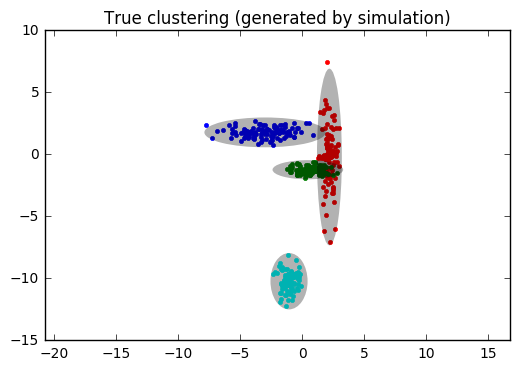

In [11]:
display_cluster_results(data, labels=c_true, mu=mu_true, sigma=sigma_true)
plt.gca().set_title("True clustering (generated by simulation)")
plt.gca().axis('equal')
None

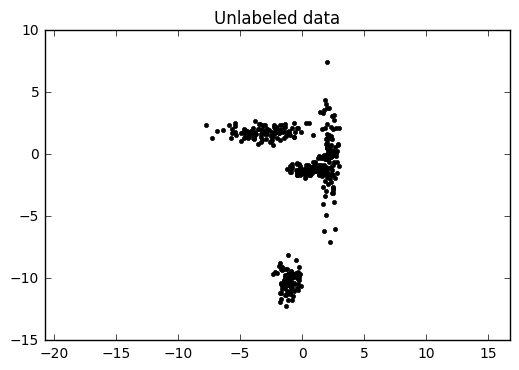

In [12]:
plt.plot(data[:,0], data[:,1], 'k.')
plt.gca().axis('equal')
plt.gca().set_title("Unlabeled data")
None

In [13]:
def softmax(x):
    '''A version of the softmax function that avoids numerical overflow.
    The softmax is computed separately for each row.'''
    x = np.asarray(x)
    x = x - np.max(x, axis=-1, keepdims=True)
    x = np.exp(x)
    result = np.true_divide(x, np.sum(x, axis=-1, keepdims=True))
    return result

In [14]:
def compute_elbo(x,
        r, alpha, beta1, beta2,  # fixed hyperparameters
        phi, m, s2, a, b):          # variational parameters for latent variables
    # Compute expected values
    Emu2 = s2 + m**2
    Eloglambda = np.log(b) - digamma(a)
    Elambdainv = a / b
    # Compute entropy
    entropy_c = -np.sum(phi * np.log(phi))
    entropy_mu = -np.sum(-0.5 * np.log(2 * np.pi * s2) - 0.5)
    entropy_lambda = -np.sum(a * np.log(b) - (a + 1) * Eloglambda - b * Elambdainv - np.log(gamma(a)))
    entropy_q = entropy_c + entropy_mu + entropy_lambda
    # Compute joint probability
    ElogJointProb = (-np.sum(Emu2 / (2.0 * alpha**2) + (beta1 + 1) * Eloglambda + beta2 * Elambdainv)
        + np.sum(phi * np.log(r)[np.newaxis,:])
        - 0.5 * np.sum(phi[:,:,np.newaxis] * Eloglambda[np.newaxis,:,:])
        - 0.5 * np.sum(phi[:,:,np.newaxis] * Elambdainv[np.newaxis,:,:] * (
            x[:,np.newaxis,:]**2 - 2 * x[:,np.newaxis,:] * m[np.newaxis,:,:] + Emu2[np.newaxis,:,:])))

    elbo = ElogJointProb + entropy_q
    return elbo

In [15]:
def variational_inference(x, r, alpha, beta1, beta2, num_iters=1000):
    x = np.asarray(x)
    r = np.asarray(r).flatten()
    n, d = x.shape
    K = len(r)

    history = defaultdict(list)

    mean = np.mean(x, axis=0)
    mean_variance = np.mean(np.var(x, axis=0))

    # Initialize variational parameters
    log_phi = np.repeat(np.atleast_2d(np.log(r)), repeats=n, axis=0) + np.random.uniform(0, 0.2, (n, K))
    phi = softmax(log_phi)
    m = mean * np.ones((K, d)) + 0.5 * mean_variance * np.random.normal(0, 1, (K, d))
    s2 = np.ones((K, d)) * mean_variance
    default_a = 0.1
    a = default_a * np.ones((K, d))
    b = mean_variance * (1 + default_a) * np.ones((K, d))

    def update_history():
        history["m"].append(m.copy())
        history["s2"].append(s2.copy())
        history["a"].append(a.copy())
        history["b"].append(b.copy())
        history["phi"].append(phi.copy())
        # Include maximum a posteriori estimates of several quantities
        history["mu_MAP"].append(m.copy())
        history["sigma_MAP"].append(np.sqrt(b / (a + 1.0)))
        history["c_MAP"].append(np.argmax(phi, axis=1))
        # Compute the ELBO
        elbo = compute_elbo(x=x, r=r, alpha=alpha, beta1=beta1, beta2=beta2, phi=phi, m=m, s2=s2, a=a, b=b)
        history["ELBO"].append(elbo)

    update_history()

    for iter_index in range(num_iters):
        for i in range(n):
            for k in range(K):
                log_phi[i, k] = (np.log(r[k]) - 0.5 * np.sum(
                    np.log(b[k,:])
                    - digamma(a[k,:])
                    + a[k,:] / b[k,:] * (
                        x[i,:]**2 - 2 * x[i,:] * m[k,:] + s2[k,:] + m[k,:] ** 2
                    )
                ))
        phi = softmax(log_phi)

        for k in range(K):
            for ell in range(d):
                m[k,ell] = (np.inner(x[:,ell], phi[:,k])) / ( b[k,ell] / (alpha**2 * a[k,ell]) + np.sum(phi[:,k]) )
                s2[k,ell] = 1.0 / (alpha**-2 + a[k,ell] / b[k,ell] * np.sum(phi[:,k]))
                
        for k in range(K):
            for ell in range(d):
                a[k,ell] = beta1 + 0.5 * np.sum(phi[:,k])
                b[k,ell] = beta2 + 0.5 * np.inner(
                    phi[:,k],
                    x[:,ell]**2 - 2 * x[:,ell] * m[k,ell] + s2[k,ell] + m[k,ell]**2)
        update_history()

    return m, s2, a, b, phi, history

In [16]:
%%time
m, s2, a, b, phi, history = variational_inference(
    x=data, r=r, alpha=alpha, beta1=beta1, beta2=beta2, num_iters=100)

CPU times: user 3.23 s, sys: 41.5 ms, total: 3.27 s
Wall time: 3.35 s


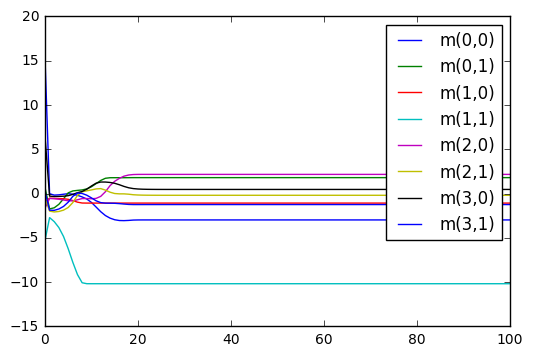

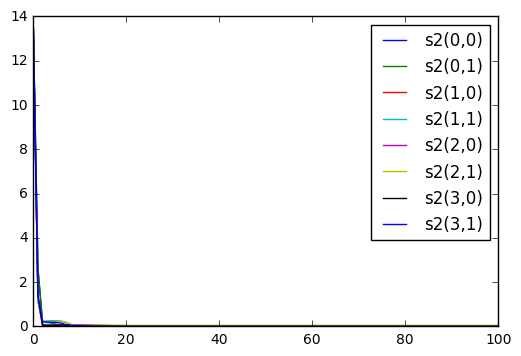

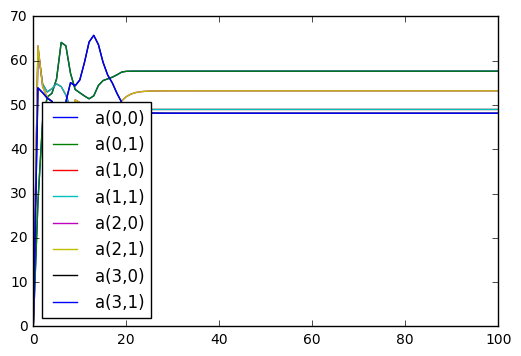

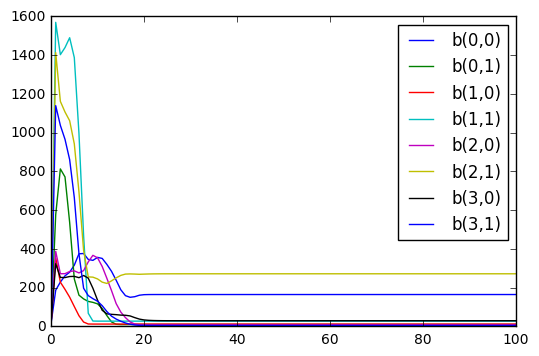

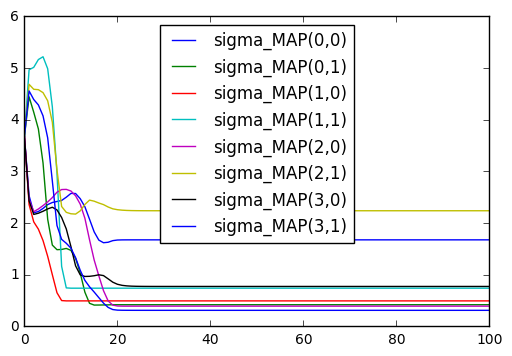

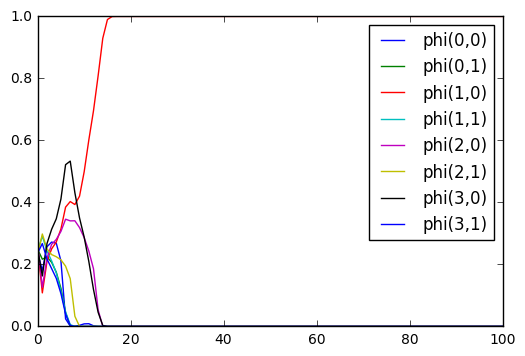

In [17]:
hist_len = len(history["phi"])
t = np.arange(hist_len, dtype='int')

stats_to_plot = ['m', 's2', 'a', 'b', 'sigma_MAP', 'phi']

for stat_name in stats_to_plot:
    fig, ax = plt.subplots()
    for k in range(K):
        for ell in range(d):
            ax.plot(t, [history[stat_name][i][k, ell] for i in t], label="{}({},{})".format(stat_name, k, ell))
    ax.legend(loc='best')

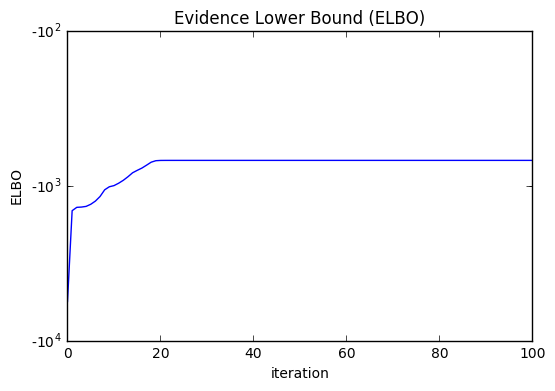

In [18]:
fig, ax = plt.subplots()
ax.plot(t, [history["ELBO"][i] for i in t])
ax.set_yscale('symlog')
ax.set_xlabel('iteration')
ax.set_ylabel('ELBO')
ax.set_title('Evidence Lower Bound (ELBO)')
None

In [19]:
mu_MAP = history["mu_MAP"][-1]
sigma_MAP = history["sigma_MAP"][-1]
c_MAP = history["c_MAP"][-1]

In [20]:
print mu_MAP
print sigma_MAP
print c_MAP

[[ -2.97408199   1.80170514]
 [ -1.07233241 -10.1758704 ]
 [  2.16676388  -0.19174039]
 [  0.46821331  -1.23940563]]
[[ 1.6760281   0.42021156]
 [ 0.49464701  0.74054043]
 [ 0.39275348  2.23928175]
 [ 0.77421937  0.31181318]]
[2 0 3 2 2 2 3 2 2 3 2 1 1 2 0 0 1 0 0 0 3 0 1 3 1 1 1 2 0 1 0 1 1 2 2 1 1
 1 3 3 0 3 3 3 1 2 0 0 1 2 0 0 3 2 2 2 1 3 2 3 3 0 1 3 1 2 3 2 3 3 3 3 2 2
 2 0 3 0 3 3 0 0 3 1 2 2 0 3 2 2 0 3 2 3 0 2 0 2 1 1 3 2 1 0 2 2 1 0 3 0 3
 1 3 1 0 1 2 0 0 1 2 1 1 3 2 1 0 1 0 1 2 3 0 0 0 1 0 0 1 0 2 1 2 0 0 3 2 1
 2 1 0 2 0 2 1 2 0 3 0 3 1 1 1 2 2 3 0 3 0 2 0 0 3 2 3 0 0 1 0 2 0 2 0 2 1
 3 3 2 1 1 0 0 0 0 0 2 0 1 2 2 1 2 3 1 3 1 3 3 2 1 1 2 3 0 2 2 3 2 0 0 3 3
 3 2 1 2 3 2 1 1 2 0 1 2 1 1 2 3 2 2 2 2 0 3 1 3 1 2 0 2 1 2 2 3 2 0 0 2 2
 1 3 3 3 2 1 3 0 0 0 0 2 3 3 2 2 1 0 1 3 1 0 0 2 2 2 0 3 2 3 0 0 0 0 0 3 3
 0 0 1 1 0 1 2 1 2 0 1 3 3 1 3 1 3 3 1 3 0 2 1 0 3 1 1 1 3 0 0 1 3 3 2 2 0
 0 0 3 2 2 3 2 2 0 1 2 2 3 0 1 0 0 0 1 1 3 1 3 1 3 0 0 3 1 1 0 2 3 1 0 0 2
 0 2 2 0 0 2 1 0 1 1 0 0

In [21]:
print mu_true
print sigma_true
print c_true

[[  2.19167361  -0.20583744]
 [  0.45411223  -1.23290528]
 [ -2.99569598   1.77958887]
 [ -1.0650861  -10.22310721]]
[[ 0.33478159  2.37433108]
 [ 0.94960494  0.25799321]
 [ 1.63173738  0.40070748]
 [ 0.49890552  0.7574122 ]]
[0 2 1 0 0 0 1 0 0 1 0 3 3 0 2 2 3 2 2 2 1 2 3 1 3 3 3 0 2 3 2 3 3 0 0 3 3
 3 1 1 2 1 1 1 3 0 2 2 3 0 2 2 1 0 0 0 3 0 0 1 1 2 3 1 3 0 1 0 1 1 1 1 0 0
 0 2 1 2 1 1 2 2 1 3 0 0 2 1 0 0 2 1 0 1 2 0 2 0 3 3 1 0 3 2 0 0 3 2 1 2 1
 3 1 3 2 3 0 2 2 3 0 3 3 1 0 3 2 3 2 3 1 1 2 2 2 3 2 2 3 2 1 3 0 2 2 1 0 3
 0 3 2 1 2 1 3 0 2 1 2 1 3 3 3 0 0 1 2 1 2 0 2 2 1 0 1 2 2 3 2 0 2 0 2 0 3
 1 1 0 3 3 2 2 2 2 2 0 2 3 0 0 3 0 1 3 1 3 1 1 0 3 3 0 1 2 0 0 1 1 2 2 1 1
 1 0 3 0 1 0 3 3 0 2 3 1 3 3 0 1 0 0 0 0 2 1 3 1 3 0 2 1 3 1 0 1 0 2 2 0 0
 3 1 1 1 0 3 1 2 2 2 2 0 1 1 0 0 3 2 3 1 3 2 2 0 0 0 2 1 0 1 2 2 2 2 2 1 1
 2 2 3 3 2 3 0 3 0 2 3 1 1 3 1 3 1 1 3 1 2 0 3 2 1 3 3 3 1 2 2 3 1 1 0 0 2
 2 2 1 0 0 1 0 0 2 3 0 0 1 2 3 2 2 2 3 3 1 3 1 3 1 2 2 1 3 3 2 0 1 3 2 2 0
 2 0 0 2 2 0 3 2 3 3 2 2

In [22]:
corrected_permutation = np.array([np.argmin(np.linalg.norm(mu_MAP[i,:] - mu_true, axis=-1)) for i in range(len(mu_MAP))])
corrected_permutation

array([2, 3, 0, 1])

In [23]:
inv_corrected_permutation = np.zeros(K, dtype='int')
inv_corrected_permutation[corrected_permutation] = np.arange(K)
inv_corrected_permutation

array([2, 3, 0, 1])

In [24]:
pred_labels = np.argmax(phi, axis=1)

In [25]:
confusion_matrix = np.zeros((K, K))
for i in range(len(c_true)):
    #confusion_matrix[c_true[i], corrected_permutation[pred_labels[i]]] += 1
    confusion_matrix[c_true[i], pred_labels[i]] += 1

confusion_matrix

array([[   0.,    0.,   97.,    1.],
       [   0.,    0.,    8.,   89.],
       [ 111.,    0.,    0.,    0.],
       [   0.,   94.,    0.,    0.]])

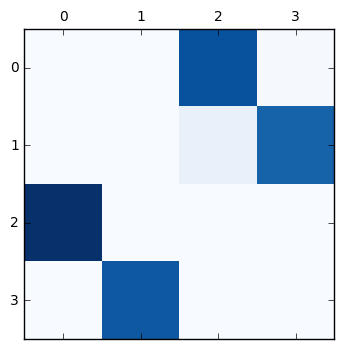

In [26]:
plt.matshow(confusion_matrix, cmap='Blues', vmin=0, vmax=np.max(confusion_matrix))
None

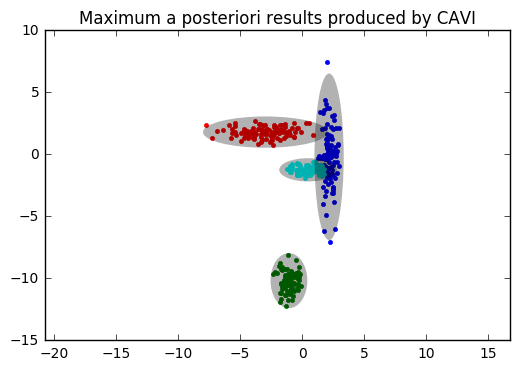

In [27]:
display_cluster_results(data, c_MAP, mu_MAP, sigma_MAP)
plt.gca().axis('equal')
plt.gca().set_title("Maximum a posteriori results produced by CAVI")
None

In [28]:
from matplotlib.animation import FuncAnimation

In [29]:
fig, ax = plt.subplots()
ax.set_title("Maximum a posteriori results produced by CAVI")
ax.axis('equal')
def update(i):
    ax.clear()
    current_pred = history["c_MAP"][i]
    current_mu = history["mu_MAP"][i]
    current_sigma = history["sigma_MAP"][i]
    display_cluster_results(data, current_pred, current_mu, current_sigma, ax)
frames = np.arange(min(30, len(history["phi"])))
#frames = np.linspace(0, len(history["phi"])-1, 30).astype('int')
anim = FuncAnimation(fig, func=update, frames=frames, interval=500)
plt.close()

In [30]:
from IPython.display import HTML

In [31]:
HTML(anim.to_html5_video())

In [32]:
entropy = -(np.ma.log(phi).filled(0) * phi).sum(axis=1)
indices_sorted = np.argsort(entropy)
max_entropy_index = indices_sorted[-1]
min_entropy_index = indices_sorted[0]

In [33]:
ranks = np.empty(len(indices_sorted), int)
ranks[indices_sorted] = np.arange(len(indices_sorted))

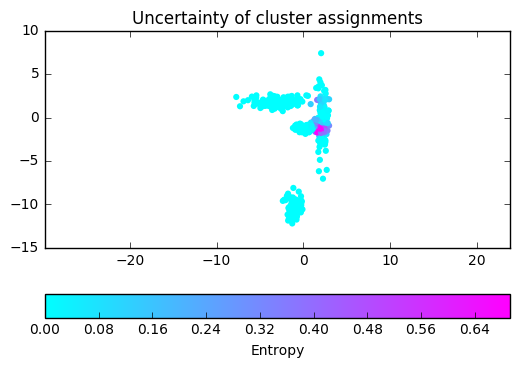

In [34]:
fig, ax = plt.subplots()
ax.axis('equal')
scatter_collection = ax.scatter(data[:,0], data[:,1], c=entropy, marker='o', edgecolor='none', cmap='cool')
ax.set_title("Uncertainty of cluster assignments")

cbar = plt.colorbar(scatter_collection, orientation='horizontal', ax=ax)
cbar.ax.set_xlabel('Entropy')
None